In [1]:
import numpy as np


from guided_diffusion import dist_util
from guided_diffusion.script_util import (
    causal_model_and_diffusion_defaults,
    create_causal_model_and_diffusion,
    match_to_dict,
)

import utils

from functools import partial
import torch

import matplotlib.pyplot as plt
from tqdm import tqdm
import ddnm
import mri_utils

/home/gluo/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/gluo/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def ddim_diffusion(xt, prompt, idx_t, model, b, T, step_size, arg_iters,  cond_func=None):
    skip = 1000 / T
    n = xt.size(0)
    losses = []

    times = ddnm.get_schedule_jump(T, 1, 1)
    time_pairs = list(zip(times[:-1], times[1:]))        

    pbar = tqdm(time_pairs)
    pbar_labels = ['loss', 'mean', 'min', 'max']
    
    for i, j in pbar:
        i, j = i*skip, j*skip
        if j<0: j=-1 

        t       = (torch.ones(n) * i).to(xt.device)
        next_t  = (torch.ones(n) * j).to(xt.device)
        at      = ddnm.compute_alpha(b, t.long())
        at_next = ddnm.compute_alpha(b, next_t.long())
        sigma_t = (1 - at_next).sqrt()[0, 0, 0, 0]
        a       = at_next.sqrt()[0, 0, 0, 0]
        
        et = model.forward_sample(torch.concat([prompt,xt],dim=1), t, idx_t=idx_t)[:, :, :2]

        xt = (1/at.sqrt()) * (xt - et * (1 - at).sqrt()) # Eq.6

        if cond_func is not None:
            for _ in range(arg_iters):
                meas_grad = cond_func(xt)             
                xt = xt - meas_grad * step_size

        if cond_func is not None:
            metrics = [(meas_grad).norm(), (xt).abs().mean(), (xt).abs().min(), (xt).abs().max()]
            ddnm.update_pbar_desc(pbar, metrics, pbar_labels)

        xt = at_next.sqrt() * xt + torch.randn_like(xt) * sigma_t # Eq.11

    return xt

In [3]:
config = utils.load_config('configs/fastmri_320_cplx.yaml')
init_config = match_to_dict(config, causal_model_and_diffusion_defaults())

device = torch.device('cuda:3')

model, diffusion = create_causal_model_and_diffusion(**init_config)
model.load_state_dict(
    dist_util.load_state_dict('/home/gluo/temporal/logs/fastmri_320_cplx/model370000.pt', map_location="cpu")
)
model = model.to(device)

betas = np.linspace(0.0001, 0.02, 1000, dtype=np.float64)
betas = torch.from_numpy(betas).float().to(device)

## Load data

In [4]:
import h5py
data = h5py.File('/scratch/gluo/compressed/fastMRI/multicoil_val/file_brain_AXT1POST_200_6002026.h5')
import utils
%matplotlib inline

In [5]:
def K_crop(kspace,shape):
    img    = mri_utils.ifft2c(kspace,axes=(0,1))
    img = mri_utils.crop(img,shape)
    kspace = mri_utils.fft2c(img,axes=(0,1))
    return kspace

def result_norm(images):
    mag_recon = np.abs(images)/np.max(np.abs(images), axis=(0,1))
    normalized_recon = mag_recon/np.linalg.norm(mag_recon, axis=(0,1), keepdims=True) 
    return normalized_recon

def pre(imgs):
    imgs = imgs[None]
    imgs = imgs / np.max(np.abs(imgs), axis=(1,2), keepdims=True)
    arr = mri_utils.cplx2float(imgs)[0]
    arr = np.transpose(arr, [2, 0, 1]).astype(np.float32) #(2,320,320)    
    arr = torch.from_numpy(arr)
    return arr

In [6]:
kspace0 = data['kspace'][0].transpose(1,2,0)
kspace1 = data['kspace'][1].transpose(1,2,0)

nx,ny,c = kspace1.shape
kspace0 = K_crop(kspace0,(ny,ny))
kspace1 = K_crop(kspace1,(ny,ny))

csm0 = utils.bart(1, 'caldir 30', kspace0[np.newaxis, ...])[0]
csm1 = utils.bart(1, 'caldir 30', kspace1[np.newaxis, ...])[0]

img0 = np.sum(mri_utils.ifft2c(kspace0,axes=(0,1)) * np.conj(csm0),-1)
img1 = np.sum(mri_utils.ifft2c(kspace1,axes=(0,1)) * np.conj(csm1),-1)

torch_img0 = pre(img0)
torch_img1 = pre(img1)

bart caldir 30 /tmp/tmprm3pmla5in0 /tmp/tmprm3pmla5out0
Calibration region 1x30x30
Done.
bart caldir 30 /tmp/tmppwmspp3ein0 /tmp/tmppwmspp3eout0
Calibration region 1x30x30
Done.


## predict Next slice

In [7]:
# prompt 
prompt = torch.zeros([1,10,2,320,320]).to(device)
prompt[:,0] = torch_img0
with torch.no_grad():
    x = torch.randn([1,1,2,320,320]).to(device)
    x = ddim_diffusion(x, prompt, 0, model, betas, T=100, step_size=2, arg_iters=4, cond_func=None)
    predict_next_slice = images = mri_utils.float2cplx(x.cpu()[0,0].permute(1,2,0))

100%|██████████| 100/100 [00:10<00:00,  9.50it/s]


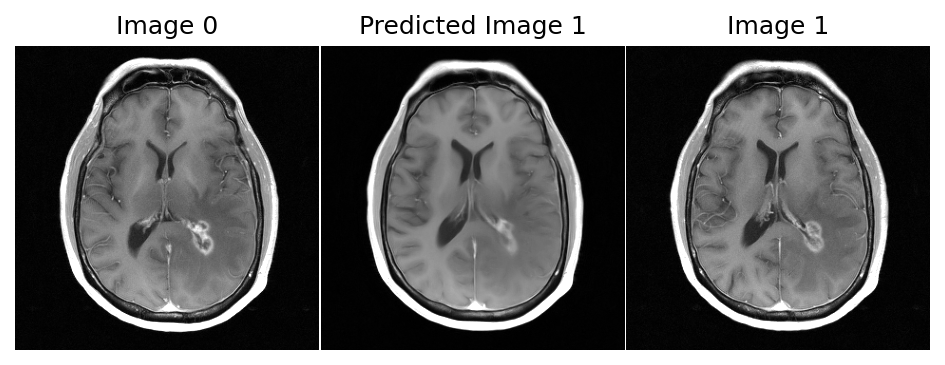

In [8]:
plt.figure(dpi=150)

vmax=0.008
plt.subplot(1,3,1)
plt.imshow(np.abs(result_norm(img0))[::-1],vmax=vmax,cmap='gray')
plt.title('Image 0')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(np.abs(result_norm(predict_next_slice))[::-1],vmax=vmax,cmap='gray')
plt.title('Predicted Image 1')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(np.abs(result_norm(img1))[::-1],vmax=vmax,cmap='gray')
plt.title('Image 1')
plt.axis('off')

plt.tight_layout(w_pad=0.1)

## MRI Reconstruction

### 4x acceleration

bart caldir 30 /tmp/tmp60otz9afin0 /tmp/tmp60otz9afout0
Calibration region 1x30x30
Done.


tensor(0.2500, device='cuda:3')

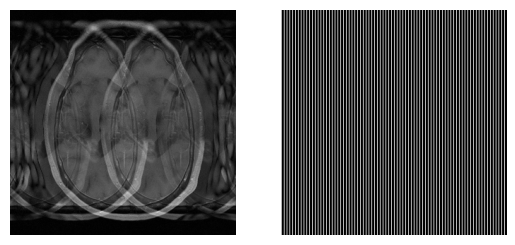

In [9]:
csm1 = utils.bart(1, 'caldir 30', kspace1[np.newaxis, ...])[0]

rss = np.sum(mri_utils.ifft2c(kspace1,axes=(0,1)) * np.conj(csm1),-1)

mask = mri_utils.equal_mask(ny,ny,4)
#mask[:, 158:162] = 1

und_ksp = kspace1*abs(mask[..., np.newaxis])

mask = np.where(und_ksp==0,0,1)[...,0]

und_ksp = torch.from_numpy(und_ksp.astype(np.complex64)).permute(2,0,1)[None].to(device)
mask    = torch.from_numpy(abs(mask).astype(np.float32))[None][None].to(device)
coilsen = torch.from_numpy(csm1.astype(np.complex64)).permute(2,0,1)[None].to(device)

zero_filled = torch.sum((mri_utils._ifft(und_ksp) * torch.conj(coilsen)),dim=1)
zero_filled = zero_filled / zero_filled.abs().max()

plt.subplot(1,2,1)
plt.imshow(zero_filled.cpu().abs()[0].numpy()[::-1],cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask.detach().cpu().squeeze(),cmap='gray')
plt.axis('off')
torch.mean(mask)

### w/ prompt

In [10]:
def cond_func(x, measurement, mask, coilsen):

    x = x[0]
    x = torch.view_as_complex(x.permute(0,2,3,1).contiguous())[:,None]
    
    x = torch.sum(mri_utils._ifft(mri_utils._fft(x * coilsen) * mask) * torch.conj(coilsen), axis=1)
    
    grad = x - measurement
    grad = torch.view_as_real(grad).permute(0,3,1,2)
    return grad[None]

grad_params = {'measurement': zero_filled*0.3, 'mask': mask, 'coilsen': coilsen}
AHA         = partial(cond_func, **grad_params)

prompt = torch.zeros([1,10,2,320,320]).to(device)
prompt[:,0] = torch_img0
with torch.no_grad():
    x = torch.randn([1,1,2,320,320]).to(device)
    x = ddim_diffusion(x, prompt, 0, model, betas, T=1000, step_size=1, arg_iters=4, cond_func=AHA)
    prompt_recon_images = mri_utils.float2cplx(x.cpu()[0,0].permute(1,2,0))

loss: 0.3665798; mean: 0.0598729; min: 0.0000000; max: 0.8035773; : 100%|██████████| 1000/1000 [01:41<00:00,  9.86it/s]


0.01361801


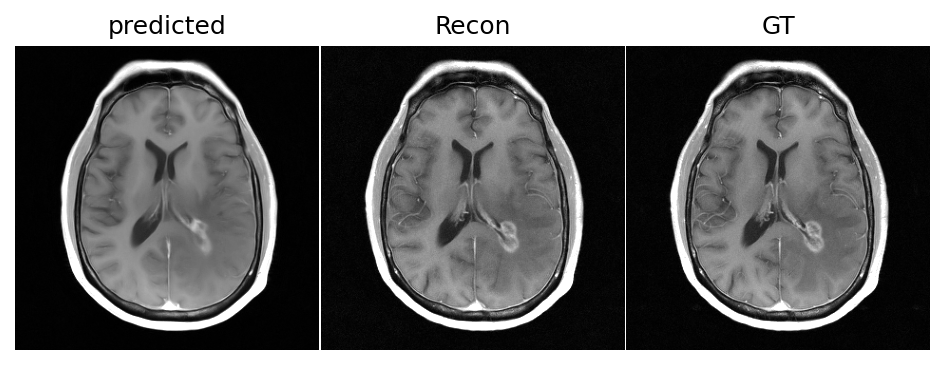

In [11]:
plt.figure(dpi=150)
print(result_norm(predict_next_slice).max())


plt.subplot(1,3,1)
plt.imshow(np.abs(result_norm(predict_next_slice))[::-1],vmax=vmax,cmap='gray')
plt.axis('off')
plt.title('predicted')

plt.subplot(1,3,2)
plt.imshow(np.abs(result_norm(prompt_recon_images))[::-1],vmax=vmax,cmap='gray')
plt.axis('off')
plt.title('Recon')

plt.subplot(1,3,3)
plt.imshow(np.abs(result_norm(img1))[::-1],vmax=vmax,cmap='gray')
plt.axis('off')
plt.title('GT')

plt.tight_layout(w_pad=0.1)

### 8x acceleration

tensor(0.1250, device='cuda:3')

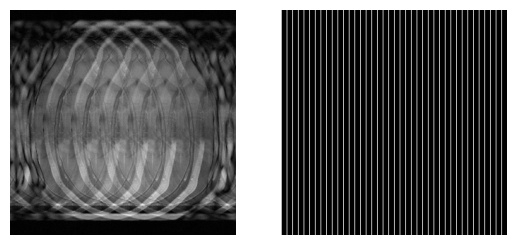

In [12]:
mask = mri_utils.equal_mask(ny,ny,8)
#mask[:, 158:162] = 1

und_ksp = kspace1*abs(mask[..., np.newaxis])

mask = np.where(und_ksp==0,0,1)[...,0]

und_ksp = torch.from_numpy(und_ksp.astype(np.complex64)).permute(2,0,1)[None].to(device)
mask    = torch.from_numpy(abs(mask).astype(np.float32))[None][None].to(device)
coilsen = torch.from_numpy(csm1.astype(np.complex64)).permute(2,0,1)[None].to(device)

zero_filled = torch.sum((mri_utils._ifft(und_ksp) * torch.conj(coilsen)),dim=1)
zero_filled = zero_filled / zero_filled.abs().max()

plt.subplot(1,2,1)
plt.imshow(zero_filled.cpu().abs()[0].numpy()[::-1],cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask.detach().cpu().squeeze(),cmap='gray')
plt.axis('off')
torch.mean(mask)

In [13]:
grad_params = {'measurement': zero_filled*0.3, 'mask': mask, 'coilsen': coilsen}
AHA         = partial(cond_func, **grad_params)

prompt = torch.zeros([1,10,2,320,320]).to(device)
prompt[:,0] = torch_img0
with torch.no_grad():
    x = torch.randn([1,1,2,320,320]).to(device)
    x = ddim_diffusion(x, prompt, 0, model, betas, T=1000, step_size=1, arg_iters=4, cond_func=AHA)
    prompt_recon_images = mri_utils.float2cplx(x.cpu()[0,0].permute(1,2,0))

loss: 0.4443814; mean: 0.0887804; min: 0.0000001; max: 1.1767677; : 100%|██████████| 1000/1000 [01:41<00:00,  9.85it/s]


0.01361801


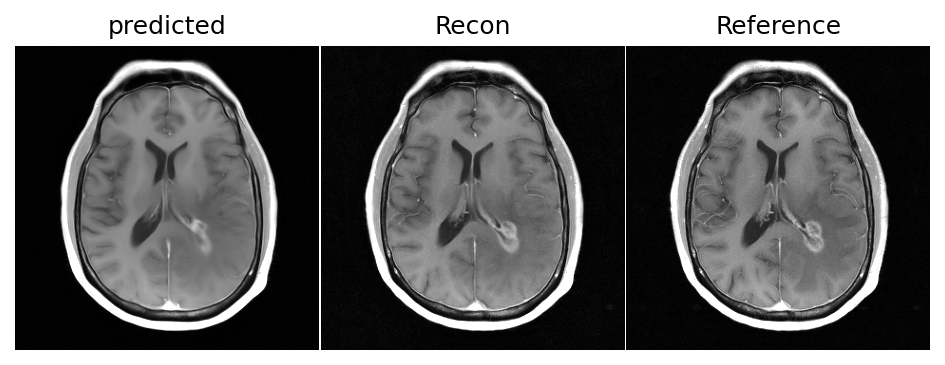

In [14]:
plt.figure(dpi=150)
print(result_norm(predict_next_slice).max())


plt.subplot(1,3,1)
plt.imshow(np.abs(result_norm(predict_next_slice))[::-1],vmax=vmax,cmap='gray')
plt.axis('off')
plt.title('predicted')

plt.subplot(1,3,2)
plt.imshow(np.abs(result_norm(prompt_recon_images))[::-1],vmax=vmax,cmap='gray')
plt.axis('off')
plt.title('Recon')

plt.subplot(1,3,3)
plt.imshow(np.abs(result_norm(img1))[::-1],vmax=vmax,cmap='gray')
plt.axis('off')
plt.title('Reference')

plt.tight_layout(w_pad=0.1)

### 12 acceleration

tensor(0.0844, device='cuda:3')

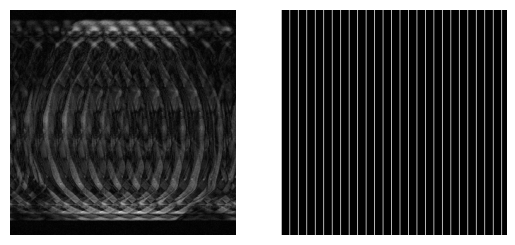

In [15]:
mask = mri_utils.equal_mask(ny,ny,12)
#mask[:, 158:162] = 1

und_ksp = kspace1*abs(mask[..., np.newaxis])

mask = np.where(und_ksp==0,0,1)[...,0]

und_ksp = torch.from_numpy(und_ksp.astype(np.complex64)).permute(2,0,1)[None].to(device)
mask    = torch.from_numpy(abs(mask).astype(np.float32))[None][None].to(device)
coilsen = torch.from_numpy(csm1.astype(np.complex64)).permute(2,0,1)[None].to(device)

zero_filled = torch.sum((mri_utils._ifft(und_ksp) * torch.conj(coilsen)),dim=1)
zero_filled = zero_filled / zero_filled.abs().max()

plt.subplot(1,2,1)
plt.imshow(zero_filled.cpu().abs()[0].numpy()[::-1],cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask.detach().cpu().squeeze(),cmap='gray')
plt.axis('off')
torch.mean(mask)

In [16]:
grad_params = {'measurement': zero_filled*0.2, 'mask': mask, 'coilsen': coilsen}
AHA         = partial(cond_func, **grad_params)

prompt = torch.zeros([1,10,2,320,320]).to(device)
prompt[:,0] = torch_img0
with torch.no_grad():
    x = torch.randn([1,1,2,320,320]).to(device)
    x = ddim_diffusion(x, prompt, 0, model, betas, T=1000, step_size=1, arg_iters=4, cond_func=AHA)
    prompt_recon_images = mri_utils.float2cplx(x.cpu()[0,0].permute(1,2,0))

loss: 0.4897790; mean: 0.0917492; min: 0.0000001; max: 1.4003720; : 100%|██████████| 1000/1000 [01:41<00:00,  9.85it/s]


0.01361801


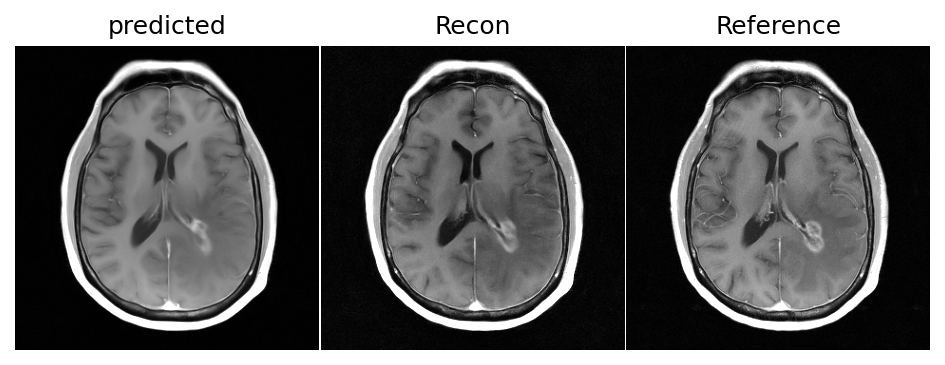

In [17]:
plt.figure(dpi=150)
print(result_norm(predict_next_slice).max())


plt.subplot(1,3,1)
plt.imshow(np.abs(result_norm(predict_next_slice))[::-1],vmax=vmax,cmap='gray')
plt.axis('off')
plt.title('predicted')

plt.subplot(1,3,2)
plt.imshow(np.abs(result_norm(prompt_recon_images))[::-1],vmax=vmax,cmap='gray')
plt.axis('off')
plt.title('Recon')

plt.subplot(1,3,3)
plt.imshow(np.abs(result_norm(img1))[::-1],vmax=vmax,cmap='gray')
plt.axis('off')
plt.title('Reference')

plt.tight_layout(w_pad=0.1)

### w/o prompt

In [18]:
prompt = torch.zeros([1,10,2,320,320]).to(device)
with torch.no_grad():
    x = torch.randn([1,1,2,320,320]).to(device)
    x = ddim_diffusion(x, prompt, 0, model, betas, T=1000, step_size=2, arg_iters=4, cond_func=AHA)
    recon_images = mri_utils.float2cplx(x.cpu()[0,0].permute(1,2,0))

loss: 0.2992195; mean: 0.0895339; min: 0.0000001; max: 1.3670639; : 100%|██████████| 1000/1000 [01:41<00:00,  9.84it/s]


0.01361801


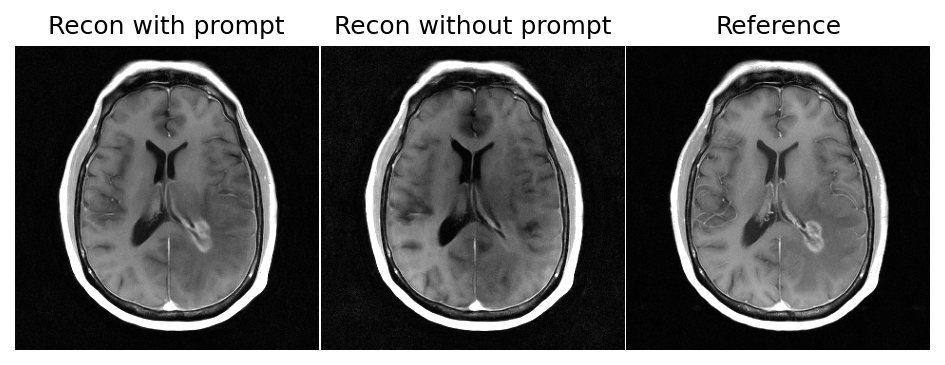

In [19]:
plt.figure(dpi=150)
print(result_norm(predict_next_slice).max())
vmax=0.008

plt.subplot(1,3,1)
plt.imshow(np.abs(result_norm(prompt_recon_images))[::-1],vmax=vmax,cmap='gray')
plt.axis('off')
plt.title('Recon with prompt')

plt.subplot(1,3,2)
plt.imshow(np.abs(result_norm(recon_images))[::-1],vmax=vmax,cmap='gray')
plt.axis('off')
plt.title('Recon without prompt')

plt.subplot(1,3,3)
plt.imshow(np.abs(result_norm(img1))[::-1],vmax=vmax,cmap='gray')
plt.axis('off')
plt.title('Reference')

plt.tight_layout(w_pad=0.1)